# Getting Started

In [2]:
# Upload Kaggle json

!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "C:/Users/nroy0/Documents/MyGitHub/Kaggle/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c fake-news -p dataset
# !kaggle datasets download -c someone/some-data -p dataset

In [2]:
!unzip /content/dataset/train.csv.zip

Archive:  /content/dataset/train.csv.zip
  inflating: train.csv               


In [3]:
!unzip /content/dataset/test.csv.zip

Archive:  /content/dataset/test.csv.zip
  inflating: test.csv                


# Imports

In [4]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10, 10]
import seaborn as sns
sns.set_theme(style="darkgrid")

from wordcloud import WordCloud
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize
import contractions

import time

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nroy0\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nroy0\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nroy0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
train_df = pd.read_csv('/content/train.csv', header=0)
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
train_df.shape

(20800, 5)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


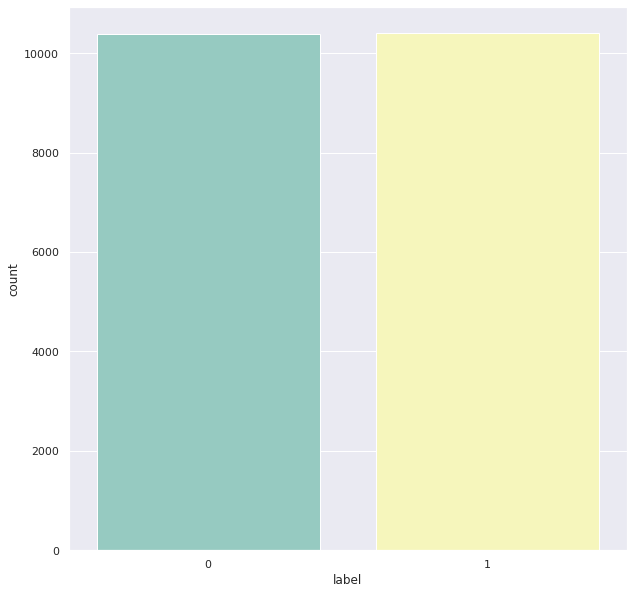

In [8]:
sns.countplot(x='label', data=train_df, palette='Set3')

In [9]:
test_df = pd.read_csv('/content/test.csv', header=0)
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [10]:
test_df.shape

(5200, 4)

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


## Drop all instances which have atleast one column missing

In [12]:
train_df.dropna(axis=0, how='any',inplace=True)
test_df.dropna(axis=0, how='any',inplace=True)

In [13]:
train_df.shape, test_df.shape

((18285, 5), (4575, 4))

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18285 non-null  int64 
 1   title   18285 non-null  object
 2   author  18285 non-null  object
 3   text    18285 non-null  object
 4   label   18285 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 857.1+ KB


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4575 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4575 non-null   int64 
 1   title   4575 non-null   object
 2   author  4575 non-null   object
 3   text    4575 non-null   object
dtypes: int64(1), object(3)
memory usage: 178.7+ KB


During prediction time title, author and text, i.e. all the current input features will be present.

## Check length of Text

In [16]:
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))

In [17]:
train_df.head()

,id,title,author,text,label,raw_text_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938


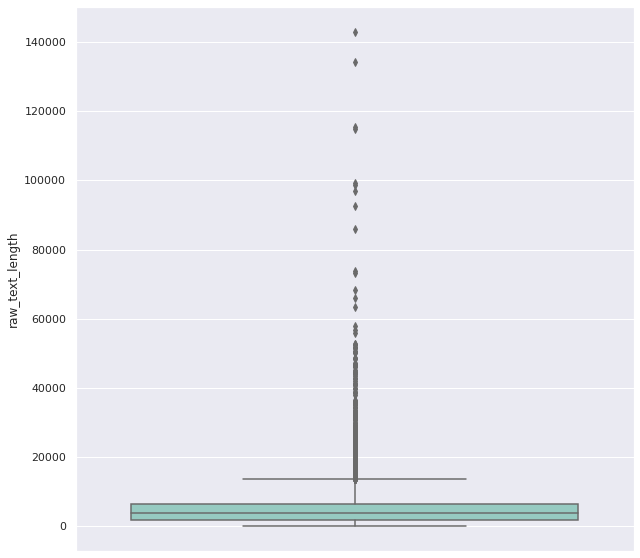

In [18]:
sns.boxplot(y='raw_text_length', data=train_df, palette="Set3")

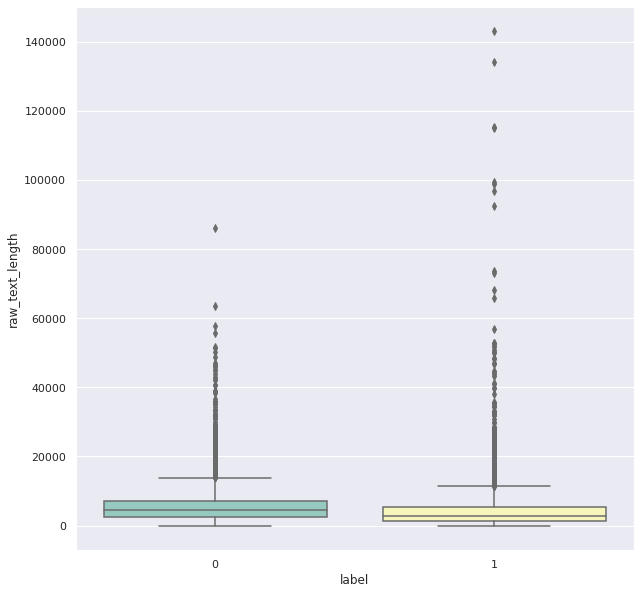

In [19]:
sns.boxplot(y='raw_text_length', x='label', data=train_df, palette="Set3")

In [20]:
len(train_df['author'].unique())

3838

In [21]:
gen_news_authors = set(list(train_df[train_df['label']==0]['author'].unique()))
fake_news_authors = set(list(train_df[train_df['label']==1]['author'].unique()))

In [22]:
overlapped_authors = gen_news_authors.intersection(fake_news_authors)

In [23]:
len(gen_news_authors), len(fake_news_authors), len(overlapped_authors)

(2225, 1618, 5)

## Text Cleaning

1. Remove special characters
2. Expand contractions
3. Convert to lower-case
4. Word Tokenize
5. Remove Stopwords

In [28]:
def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        try:
            word_list.append(contractions.fix(each_word).lower())
        except:
            print(x)
    return " ".join(word_list)

**Got Error because of some sort of Turkish/Slavic language**

ABÇin ilişkilerinde ABD ve NATOnun etkisi yazan Manlio Dinucci Uluslararası bir forumda konuşan İtalyan coğrafyacı Manlio Dinucci ABDnin tüm dünyaya egemen olabilmek için sahip olduğu silahların analizini bireşimleştirdi Suriye Rusya ve Çinin bugün elde silah herkesin açıkça kabul ettiği bu üstünlüğü dünyanın bu tek kutuplu örgütlenişi tartışılır hale getirmesinden dolayı bu makale daha da önem kazanmaktadır

Accordingly the preprocessing of the texts were executed.

In [29]:
text_cols = ['text', 'title', 'author']

In [30]:
%%time
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(lambda x: preprocess_text(x))
    test_df[col] = test_df[col].apply(lambda x: preprocess_text(x))

Processing column: text
Processing column: title
Processing column: author
CPU times: user 50.6 s, sys: 296 ms, total: 50.9 s
Wall time: 51 s


In [31]:
%%time
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(word_tokenize)
    test_df[col] = test_df[col].apply(word_tokenize)

Processing column: text
Processing column: title
Processing column: author
CPU times: user 1min 10s, sys: 513 ms, total: 1min 10s
Wall time: 1min 10s


In [32]:
%%time
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(
        lambda x: [each_word for each_word in x if each_word not in stopwords])
    test_df[col] = test_df[col].apply(
        lambda x: [each_word for each_word in x if each_word not in stopwords])

Processing column: text
Processing column: title
Processing column: author
CPU times: user 28.6 s, sys: 43.7 ms, total: 28.6 s
Wall time: 28.6 s


In [33]:
train_df.head()

,id,title,author,text,label,raw_text_length
0,0,"[house, dem, aide, even, see, comeys, letter, ...","[darrell, lucus]","[house, dem, aide, even, see, comeys, letter, ...",1,4930
1,1,"[flynn, hillary, clinton, big, woman, campus, ...","[daniel, j, flynn]","[ever, get, feeling, life, circles, roundabout...",0,4160
2,2,"[truth, might, get, fired]",[consortiumnewscom],"[truth, might, get, fired, october, 29, 2016, ...",1,7692
3,3,"[15, civilians, killed, single, us, airstrike,...","[jessica, purkiss]","[videos, 15, civilians, killed, single, us, ai...",1,3237
4,4,"[iranian, woman, jailed, fictional, unpublishe...","[howard, portnoy]","[print, iranian, woman, sentenced, six, years,...",1,938


# Text Data Exploration

## World Cloud Generation

# TF-IDF Transformation

In [40]:
train_df.head()

,id,title,author,text,label,raw_text_length
0,0,"[house, dem, aide, even, see, comeys, letter, ...","[darrell, lucus]","[house, dem, aide, even, see, comeys, letter, ...",1,4930
1,1,"[flynn, hillary, clinton, big, woman, campus, ...","[daniel, j, flynn]","[ever, get, feeling, life, circles, roundabout...",0,4160
2,2,"[truth, might, get, fired]",[consortiumnewscom],"[truth, might, get, fired, october, 29, 2016, ...",1,7692
3,3,"[15, civilians, killed, single, us, airstrike,...","[jessica, purkiss]","[videos, 15, civilians, killed, single, us, ai...",1,3237
4,4,"[iranian, woman, jailed, fictional, unpublishe...","[howard, portnoy]","[print, iranian, woman, sentenced, six, years,...",1,938


In [41]:
train_df['text_joined'] = train_df['text'].apply(lambda x: " ".join(x))
test_df['text_joined'] = test_df['text'].apply(lambda x: " ".join(x))

In [42]:
train_df.head()

,id,title,author,text,label,raw_text_length,text_joined
0,0,"[house, dem, aide, even, see, comeys, letter, ...","[darrell, lucus]","[house, dem, aide, even, see, comeys, letter, ...",1,4930,house dem aide even see comeys letter jason ch...
1,1,"[flynn, hillary, clinton, big, woman, campus, ...","[daniel, j, flynn]","[ever, get, feeling, life, circles, roundabout...",0,4160,ever get feeling life circles roundabout rathe...
2,2,"[truth, might, get, fired]",[consortiumnewscom],"[truth, might, get, fired, october, 29, 2016, ...",1,7692,truth might get fired october 29 2016 tension ...
3,3,"[15, civilians, killed, single, us, airstrike,...","[jessica, purkiss]","[videos, 15, civilians, killed, single, us, ai...",1,3237,videos 15 civilians killed single us airstrike...
4,4,"[iranian, woman, jailed, fictional, unpublishe...","[howard, portnoy]","[print, iranian, woman, sentenced, six, years,...",1,938,print iranian woman sentenced six years prison...


In [43]:
tf_idf_transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

# fit train data to the count vectorizer
count_vect_train = count_vectorizer.fit_transform(train_df['text_joined'].values)

#fit the ngrams count to the tfidf transformers
tf_idf_train = tf_idf_transformer.fit_transform(count_vect_train)

In [44]:
count_vect_train

<18285x4457643 sparse matrix of type '<class 'numpy.int64'>'
	with 12940845 stored elements in Compressed Sparse Row format>

In [45]:
tf_idf_train

<18285x4457643 sparse matrix of type '<class 'numpy.float64'>'
	with 12940845 stored elements in Compressed Sparse Row format>

In [46]:
target = train_df['label'].values

# Train Test Split


In [47]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, target, random_state=0)

In [48]:
df_perf_metrics = pd.DataFrame(columns  =['Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision', 'Recall', 'f1_score'])

# Logistic Regression

In [49]:
log_reg_model = LogisticRegression(C=1e5)
log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)

In [50]:
df_perf_metrics.loc[0] = [
    "Logistic Regression",
    log_reg_model.score(X_train, y_train),
    log_reg_model.score(X_test, y_test),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    f1_score(y_test, y_pred)
]

In [51]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score
0,Logistic Regression,0.999927,0.970472,0.969605,0.962293,0.965935


In [52]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])


def get_perf_metrics(model, i):
    model_name = type(model).__name__
    start_time = time.time()
    print("Training {} model...".format(model_name))
    model.fit(X_train, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    y_pred = model.predict(X_test)
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    print("Completed {} model's performance assessment.".format(model_name))

In [53]:
models_list = [LogisticRegression(C=1e5),
               RandomForestClassifier(n_estimators=5),
               ExtraTreesClassifier(n_estimators=5,n_jobs=4),
               AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)]

In [54]:
%%time
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 86.78 s.
Completed LogisticRegression model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 29.26 s.
Completed RandomForestClassifier model's performance assessment.
Training ExtraTreesClassifier model...
Completed ExtraTreesClassifier model training.
Time elapsed: 45.40 s.
Completed ExtraTreesClassifier model's performance assessment.
Training AdaBoostClassifier model...
Completed AdaBoostClassifier model training.
Time elapsed: 276.41 s.
Completed AdaBoostClassifier model's performance assessment.
CPU times: user 8min 15s, sys: 40 s, total: 8min 55s
Wall time: 7min 24s


In [55]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,0.999927,0.970472,0.969605,0.962293,0.965935,86.78
1,RandomForestClassifier,0.983082,0.807743,0.816781,0.719457,0.765036,29.26
2,ExtraTreesClassifier,0.999927,0.847113,0.878521,0.752640,0.810723,45.40
3,AdaBoostClassifier,0.904689,0.896763,0.872727,0.892911,0.882704,276.41


# Adding Title and Author Information to the Text

In [56]:
train_df['all_info'] = train_df['text'] + train_df['title'] + train_df['author'] 
train_df['all_info'] = train_df['all_info'].apply(lambda x: " ".join(x))

test_df['all_info'] = test_df['text'] + test_df['title'] + test_df['author'] 
test_df['all_info'] = test_df['all_info'].apply(lambda x: " ".join(x))

In [57]:
tf_idf_transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

# fit train data to the count vectorizer
count_vect_train = count_vectorizer.fit_transform(train_df['all_info'].values)

#fit the ngrams count to the tfidf transformers
tf_idf_train = tf_idf_transformer.fit_transform(count_vect_train)

X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, target, random_state=0)

In [58]:
%%time
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 90.41 s.
Completed LogisticRegression model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 19.83 s.
Completed RandomForestClassifier model's performance assessment.
Training ExtraTreesClassifier model...
Completed ExtraTreesClassifier model training.
Time elapsed: 33.60 s.
Completed ExtraTreesClassifier model's performance assessment.
Training AdaBoostClassifier model...
Completed AdaBoostClassifier model training.
Time elapsed: 276.24 s.
Completed AdaBoostClassifier model's performance assessment.
CPU times: user 7min 49s, sys: 40.4 s, total: 8min 29s
Wall time: 7min 6s


In [59]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,1.000000,0.979878,0.978316,0.975365,0.976838,90.41
1,RandomForestClassifier,0.987311,0.831802,0.837763,0.760684,0.797365,19.83
2,ExtraTreesClassifier,1.000000,0.861986,0.887557,0.781800,0.831329,33.60
3,AdaBoostClassifier,0.963976,0.956693,0.941350,0.960282,0.950722,276.24


# NLP using Deep Learning with Keras

In [60]:
all_text = train_df["all_info"].astype(str).tolist()
all_text[0]

"house dem aide even see comeys letter jason chaffetz tweeted darrell lucus october 30 2016 subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative commonsby license apologies keith olbermann doubt worst person world weekfbi director james comey according house democratic aide looks like also know secondworst person well turns comey sent nowinfamous letter announcing fbi looking emails may related hillary clintons email server ranking democrats relevant committees hear comey found via tweet one republican committee chairmen know comey notified republican chairmen democratic ranking members house intelligence judiciary oversight committees agency reviewing emails recently discovered order see contained classified information long letter went oversight committee chairman jason chaffetz set political world ablaze tweet fbi dir informed fbi learned existence emails appear pertinent investigation case reopened jason chaffetz jasoninthehouse october

In [61]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)
tokenizer.fit_on_texts(all_text)
word_index = tokenizer.word_index
len(word_index)

177027

In [62]:
sequences = tokenizer.texts_to_sequences(all_text)
padded = pad_sequences(sequences, padding = 'post', maxlen=6000)
padded[0]

array([  40, 4881, 2085, ...,    0,    0,    0], dtype=int32)

In [63]:
padded.shape

(18285, 6000)

In [110]:
def get_model():
    model=Sequential()
    model.add(Embedding(6000, 300 ,input_length=6000))
    model.add(Dropout(0.3))
    model.add(LSTM(200))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    return model

model = get_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 6000, 300)         1800000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 6000, 300)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               400800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 201       
Total params: 2,201,001
Trainable params: 2,201,001
Non-trainable params: 0
_________________________________________________________________


In [111]:
X_train, X_test, y_train, y_test = train_test_split(padded, target, test_size=0.2)

In [112]:
callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, 
                                  verbose=1, mode="min", restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath="best_model.hdf5", verbose=1, save_best_only=True)
]

In [114]:
model = get_model()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [116]:
%%time
history = model.fit([X_train], 
                    y_train, 
                    epochs=10,
                    batch_size=64, 
                    validation_data=([X_test], y_test), 
                    callbacks=callbacks)

Epoch 1/10
229/229 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5669
Epoch 00001: val_loss improved from inf to 0.68412, saving model to best_model.hdf5
229/229 [==============================] - 179s 783ms/step - loss: 0.6853 - accuracy: 0.5669 - val_loss: 0.6841 - val_accuracy: 0.5663
Epoch 2/10
229/229 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5668
Epoch 00002: val_loss did not improve from 0.68412
229/229 [==============================] - 181s 791ms/step - loss: 0.6853 - accuracy: 0.5668 - val_loss: 0.6842 - val_accuracy: 0.5669
Epoch 3/10
229/229 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5669
Epoch 00003: val_loss did not improve from 0.68412
229/229 [==============================] - 181s 792ms/step - loss: 0.6848 - accuracy: 0.5669 - val_loss: 0.6852 - val_accuracy: 0.5671
Epoch 4/10
229/229 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.5669
Epoch 00004: val_loss did

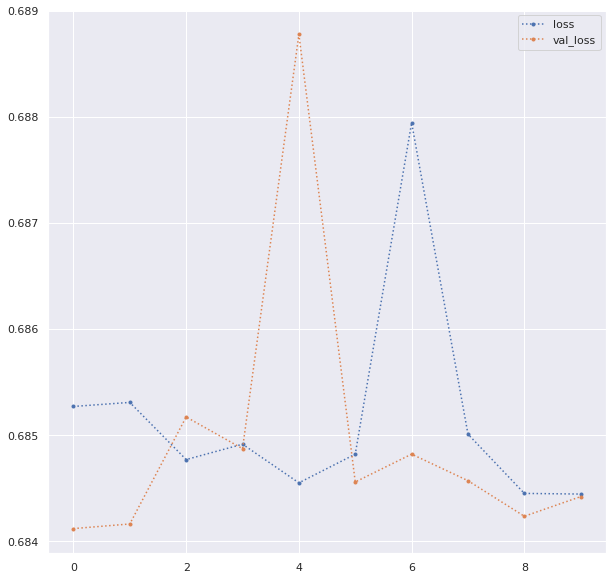

In [117]:
metric_toplot = "loss"
plt.plot(history.epoch, history.history[metric_toplot], ".:", label="loss")
plt.plot(history.epoch,
         history.history["val_" + metric_toplot],
         ".:",
         label="val_loss")
plt.legend()

In [100]:
model = keras.models.load_model('best_model.hdf5')

In [118]:
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [119]:
y_test.shape, y_pred.shape

((3657,), (3657, 1))

In [120]:
precision_score(y_test, y_pred)

1.0

In [121]:
confusion_matrix(y_test, y_pred)

array([[2071,    0],
       [1584,    2]])

In [122]:
recall_score(y_test, y_pred)

0.0012610340479192938